In [ ]:
!rm -rf /content/*
!pip install --upgrade --no-cache-dir gdown
from IPython.display import clear_output
clear_output()

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beckoliver","key":"848de19a3d6d1fc6166df8bd32d747f1"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mateohervas/dcsass-dataset
! unzip /content/dcsass-dataset.zip -d /content
! rm /content/dcsass-dataset.zip

clear_output()

In [ ]:
import pandas as pd

def filter_df(path):
    df = pd.read_csv(path,names=['file_name', 'label','class'])
    df['file_name'] = df['file_name'].apply(lambda x:x+'.mp4')
    df = df[df['class'] == 1]
    file_names = df['file_name'].unique().tolist()
    return file_names

In [ ]:
import os
from tqdm.auto import tqdm
old_folder = os.path.join('/content','DCSASS Dataset')
labels_files = os.path.join(old_folder,'Labels')
file_paths = {}

for i in tqdm(os.listdir(old_folder)):
    if i == 'Labels':
        continue

    l1 = os.listdir(os.path.join(old_folder,i))
    path = os.path.join(labels_files, i+'.csv')
    files = filter_df(path)
    file_paths[i] = []
    for j in l1:
        l2 = os.listdir(os.path.join(old_folder,i,j))
        for k in l2:
            if k in files:
                file_paths[i].append(os.path.join(old_folder,i,j,k))

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
!rm -rf video_data
!mkdir video_data

In [ ]:
new_folder = os.path.join('/content','video_data')
th = 50

for i,j in tqdm(file_paths.items()):
    os.mkdir(os.path.join(new_folder,i))
    for idx,k in enumerate(j):
        file_name = k.split('/')[-1]
        dest_path = os.path.join(new_folder,i,file_name)
        os.rename(k,dest_path)
        if (idx+1) == th:
            break

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

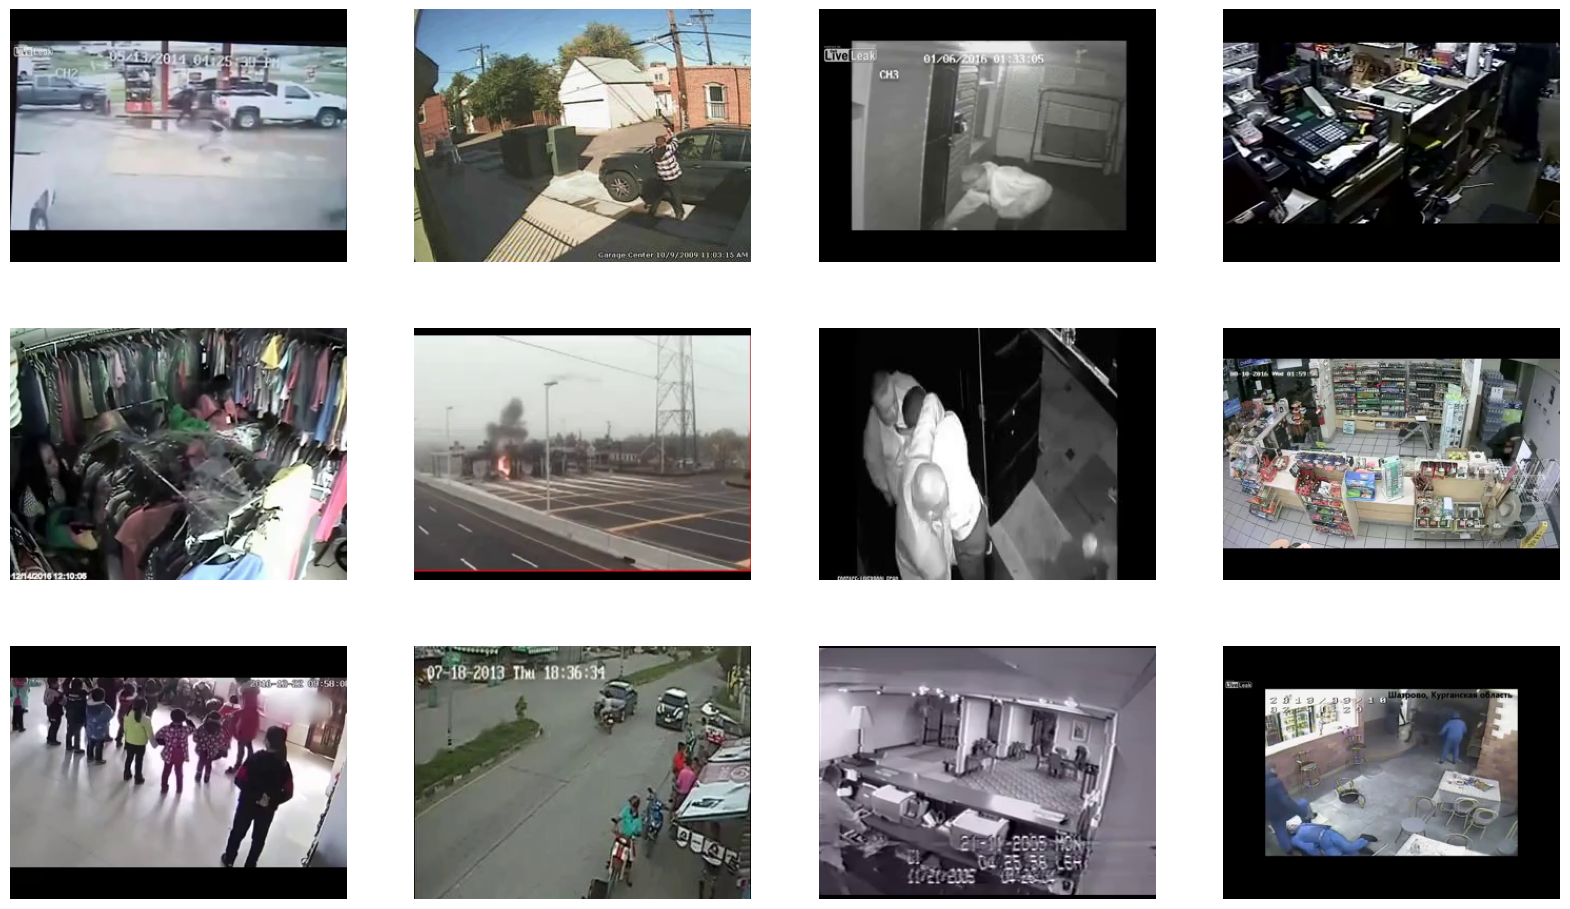

In [ ]:

plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('/content/video_data')

random_range = random.sample(range(len(all_classes_names)), 12)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/content/video_data/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/content/video_data/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "/content/video_data/"
CLASSES_LIST = ['Robbery',
 'Explosion',
 'Shoplifting',
 'Arrest',
 'Fighting',
 'RoadAccidents']

In [ ]:
def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Robbery
Extracting Data of Class: Explosion
Extracting Data of Class: Shoplifting
Extracting Data of Class: Arrest
Extracting Data of Class: Fighting
Extracting Data of Class: RoadAccidents


In [ ]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

#Quantum LSTM Model

In [ ]:
# Install Pennylane
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(features, weights):
    qml.templates.AngleEmbedding(features, wires=range(2))
    qml.templates.BasicEntanglerLayers(weights, wires=range(2))
    return qml.expval(qml.PauliZ(0))

def model(features, weights):
    return circuit(features, weights)

def cost(weights, features, labels):
    predictions = [model(f, weights) for f in features]
    return np.square(np.array(predictions) - np.array(labels)).mean()

def cost_grad(weights, features, labels):
    predictions = [model(f, weights) for f in features]


In [ ]:
np.random.seed(0)
features = np.array([[np.pi * np.random.uniform(), 2 * np.pi * np.random.uniform()] for _ in range(100)])
labels = np.array([1 if features[i][0] < np.pi else -1 for i in range(100)])

weights = np.random.random(size=(50, 2))

optimizer = GradientDescentOptimizer(stepsize=0.5)

opt_weights = optimizer.step(lambda w: cost(w, features, labels), weights)

In [ ]:

def Quantum_Model(weights):

    model = tf.keras.Sequential()

    weights, prev_cost = optimizer.step_and_cost(lambda w: cost(w, features, labels), weights)

    model.add(tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))
    model.summary()

    return model

In [ ]:
ql_model = Quantum_Model(weights)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

ql_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

training_history = ql_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
45/45 [==============================] - 21s 267ms/step - loss: 1.6136 - accuracy: 0.3722 - val_loss: 1.2877 - val_accuracy: 0.4444
Epoch 2/50
45/45 [==============================] - 17s 393ms/step - loss: 1.1638 - accuracy: 0.6222 - val_loss: 0.8501 - val_accuracy: 0.6889
Epoch 3/50
45/45 [==============================] - 11s 238ms/step - loss: 0.6574 - accuracy: 0.7389 - val_loss: 0.3765 - val_accuracy: 0.8222
Epoch 4/50
45/45 [==============================] - 10s 234ms/step - loss: 0.3558 - accuracy: 0.9056 - val_loss: 0.2428 - val_accuracy: 0.9333
Epoch 5/50
45/45 [==============================] - 12s 269ms/step - loss: 0.1659 - accuracy: 0.9611 - val_loss: 0.3624 - val_accuracy: 0.8222
Epoch 6/50
45/45 [==============================] - 17s 380ms/step - loss: 0.2511 - accuracy: 0.9111 - val_loss: 0.6623 - val_accuracy: 0.8000
Epoch 7/50
45/45 [==============================] - 19s 415ms/step - loss: 0.2466 - accuracy: 0.9278 - val_loss: 0.3531 - val_accuracy: 0.8889

In [ ]:
eval_history = ql_model.evaluate(features_test, labels_test)

3/3 [==============================] - 1s 208ms/step - loss: 0.3661 - accuracy: 0.9467


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = eval_history
ql_model.save('model.h5')

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

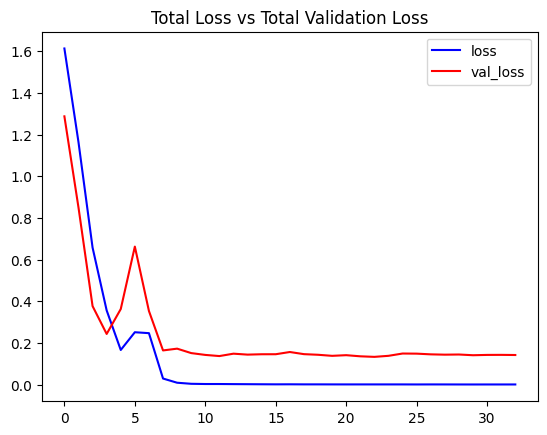

In [ ]:
plot_metric(training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

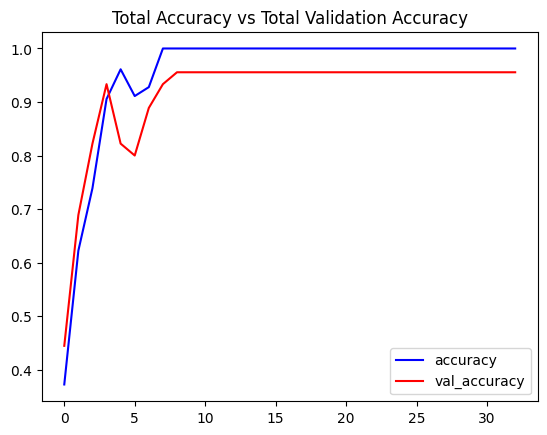

In [ ]:
plot_metric(training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
!pip install mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00


In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list


In [ ]:
def vid_class_pred(path,class_list):
    arr = np.array(frames_extraction(path))
    arr = np.expand_dims(arr, axis=0)
    model_pred = ql_model.predict(arr).ravel()
    pred_prob = max(model_pred)
    pred_class = class_list[np.argmax(model_pred)]
    return pred_class,pred_prob

In [ ]:
import mediapy as media
vid_path = '/content/video_data/RoadAccidents/RoadAccidents008_x264_25.mp4'

video = media.read_video(vid_path)
media.show_video(video, fps=30)

In [ ]:
pred,prob = vid_class_pred(vid_path,CLASSES_LIST)
pred,prob

1/1 [==============================] - 0s 95ms/step


('RoadAccidents', 0.9998357)